# n-dimensional convolution

In [2]:
import bruges
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import welly

In [4]:
well = welly.Well.from_las('../data/R-39.las')

In [5]:
vp = 1e6 / well.data['DT4P']
vs = 1e6 / well.data['DT4S']
rho = well.data['RHOB']

In [6]:
rc = bruges.reflection.reflectivity(vp, vs, rho, theta=np.arange(60))

In [9]:
w, t = bruges.filters.ricker(0.128, 0.001, 25, return_t=True)

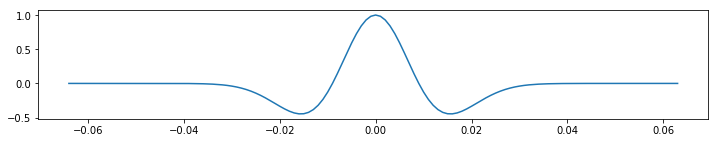

In [11]:
plt.figure(figsize=(12,2))
plt.plot(t, w)
plt.show()

## Convolutional operator

In [12]:
import scipy.signal

In [13]:
from scipy import linalg as spla
def convmtx(h, n):
    col_1 = np.r_[h[0], np.zeros(n-1)]
    row_1 = np.r_[h, np.zeros(n-1)]
    return spla.toeplitz(col_1, row_1)

In [14]:
# Forward operator and dot product.
G = convmtx(w, rc.shape[1])
%timeit syn = G.T @ rc.T

569 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
syn = G.T @ rc.T

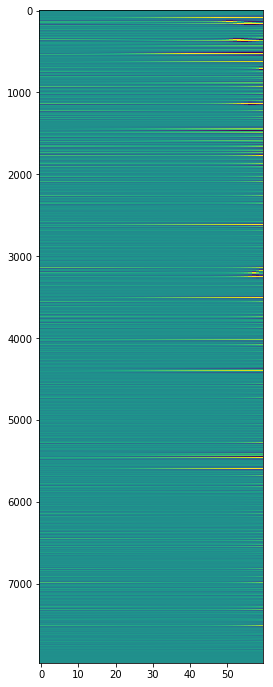

In [19]:
plt.figure(figsize=(4, 12))
plt.imshow(syn.real, aspect='auto', vmin=-0.5, vmax=0.5)

## Apply along axis

In [8]:
# np.apply_along_axis()
%timeit syn = np.apply_along_axis(lambda tr: np.convolve(tr, w, mode='same'), arr=rc, axis=-1)

34.1 ms ± 680 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# map()
%timeit syn = np.array(list(map(lambda tr: np.convolve(tr, w, mode='same'), rc)))

35 ms ± 292 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
# List comprehension.
%timeit syn = np.array([np.convolve(tr, w, mode='same') for tr in rc])

34.8 ms ± 664 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
# 2D convolution.
%timeit syn = scipy.signal.fftconvolve(rc, np.expand_dims(w, 0), mode='same')

61.4 ms ± 608 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
# 2D convolution.
%timeit syn = scipy.signal.convolve(rc, np.expand_dims(w, 0), mode='same')

68.3 ms ± 578 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
# 2D convolution.
%timeit syn = scipy.signal.convolve2d(rc, np.expand_dims(w, 0), mode='same')

221 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
syn = np.apply_along_axis(lambda tr: np.convolve(tr, w, mode='same'), arr=rc, axis=-1)

In [ ]:
b.transform.CoordTransform

In [150]:
_ = b.filters.wavelets.ricker(0.128, 0.001, 25)

In [151]:
_ = b.filters.ricker(0.128, 0.001, 25)